In [1]:
import numpy as np
from scipy.linalg import eigh_tridiagonal

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

import sympy as sp
from scipy.optimize import bisect
from scipy.special import hermite,assoc_laguerre

In [2]:
def get_H(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    T_ = -(np.diag(np.full(n-3,1),k=-1) + np.diag(np.full(n-2,-2),k=0) + np.diag(np.full(n-3,1),k=1))/h**2
    V_ = np.diag(V(x[1:-1]))
    H  = T_ + V_
    
    return x,H

In [3]:
def solve_SE(x0,x1,n,V):
    x = np.linspace(x0,x1,n)
    h = x[1] - x[0]
    
    d = -np.full(n-2,-2)/h**2 + V(x[1:-1])
    e = -np.full(n-3,1)/h**2
    
    E,psi = eigh_tridiagonal(d,e)
    psi   = np.vstack(([np.zeros(E.shape[0]),psi,np.zeros(E.shape[0])]))
    return x,E,psi.T

# Finite square well

### analytic stuff

In [ ]:
A,B,C,D      = sp.symbols(r'A B C D')
k,kappa,V0,a = sp.symbols(r'k \kappa V_0 a',real=True,positive=True)
u            = sp.Symbol(r'u')

psi1 = A*sp.exp(kappa*u)
psi2 = B*sp.cos(k*u) + C*sp.sin(k*u)
psi3 = D*sp.exp(-kappa*u)

BC1 = sp.Eq(psi1.subs(u,-1)        ,psi2.subs(u,-1))
BC2 = sp.Eq(psi1.diff(u).subs(u,-1),psi2.diff(u).subs(u,-1))
BC3 = sp.Eq(psi2.subs(u,1)         ,psi3.subs(u,1))
BC4 = sp.Eq(psi2.diff(u).subs(u,1) ,psi3.diff(u).subs(u,1))

display(BC1)
display(BC2)
display(BC3)
display(BC4)

In [ ]:
A_ = sp.solve(BC1,A,dict=True)[0][A]
D_ = sp.solve(BC3,D,dict=True)[0][D]

display(sp.Eq(A,A_))
display(sp.Eq(D,D_))

BC2 = BC2.subs(A,A_).simplify()
BC4 = BC4.subs(D,D_).simplify()

display(BC2.expand())
display(BC4.expand())

In [ ]:
norm = sp.integrate(psi1**2,(u,-sp.oo,-1)) + sp.integrate(psi2**2,(u,-1,1)) + sp.integrate(psi3**2,(u,1,sp.oo))
norm.subs(A,A_).subs(D,D_).simplify().subs(B,0).simplify()

In [99]:
def get_finite_well_E(V0):
    f1 = lambda t: t*np.tan(t) - np.sqrt(V0 - t**2)
    f2 = lambda t: t/np.tan(t) + np.sqrt(V0 - t**2)
    
    k     = []
    ab    = np.array([1e-5,(1-1e-5)*np.pi/2])
    k_max = np.sqrt(V0)
    N     = np.ceil(2*k_max/np.pi).astype(int)
    for i in range(N):
        if ab[-1] > k_max:
            ab[-1] = (1-1e-16)*k_max
        
        f = f1 if i%2==0 else f2
        k.append(bisect(f,*ab))
        
        ab += np.pi/2
        
    E = np.array(k)**2
    return E

In [100]:
def get_finite_well_psi(u,V0):
    temp = get_finite_well_E(V0)
    k    = np.sqrt(temp)
    U,K  = np.meshgrid(u,k)
    
    kappa = np.sqrt(V0 - K**2)
    n     = np.arange(temp.shape[0])
    
    B = 1/np.sqrt(1 + np.sin(2*K)/2/K + np.cos(K)**2/kappa)
    B[n%2==1] = 0
    C = 1/np.sqrt(1 - np.sin(2*K)/2/K + np.sin(K)**2/kappa)
    C[n%2==0] = 0
    
    A = (B*np.cos(K) - C*np.sin(K))*np.exp(kappa)
    D = (B*np.cos(K) + C*np.sin(K))*np.exp(kappa)
    
    return temp,A*np.exp(kappa*U)*(U<-1) + (B*np.cos(K*U) + C*np.sin(K*U))*(np.abs(U) < 1) + D*np.exp(-kappa*U)*(U>1)

In [101]:
V0 = 10
E_  = get_finite_well_E(V0)
# k_  = np.sqrt(E)
# kappa_ = np.sqrt(V0 - E)

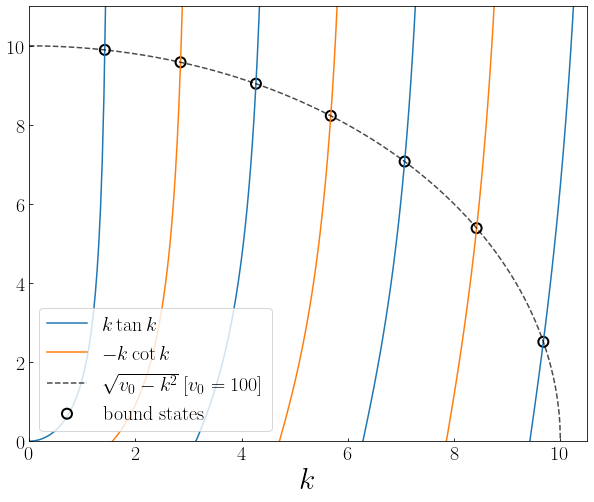

In [102]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

v0 = 100
N  = np.ceil(np.pi*np.sqrt(v0)/np.pi).astype(int)
for i in range(0,N):
    k = np.linspace(1e-10+i*np.pi/2,(i+1)*np.pi/2-1e-10)
    ax.plot(k,k*np.tan(k),'C0',label=r'$k \tan{k}$' if i==0 else '')
    ax.plot(k,-k/np.tan(k),'C1',label=r'$-k \cot{k}$' if i==0 else '')

k = np.linspace(1e-10,np.sqrt(v0)-1e-10,1000)
ax.plot(k,np.sqrt(v0-k**2),'k--',alpha=0.7,label=r'$\sqrt{v_0 - k^2}~[v_0 = %d]$'%v0)

E_  = get_finite_well_E(v0)
k_  = np.sqrt(E_)
n_  = np.arange(k_.shape[0])
lhs = k_*(np.tan(k_)*(n_%2==0) - 1/np.tan(k_)*(n_%2==1))
ax.scatter(k_,lhs,color='None',marker='o',edgecolor='k',s=100,lw=2,label=r'$\rm bound~states$')

ax.set_xlim(0,1.05*np.sqrt(v0))
ax.set_ylim(0,1.1*np.sqrt(v0))
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)
ax.set_xlabel(r'$k$',size=30)
ax.legend(fontsize=20,loc='lower left',frameon=True)

plt.show()
fig.savefig(r'finite_well_exact_solutions.pdf',bbox_inches='tight')

### numerical stuff

-- to do: comparison with analytic solutions (transcendental equation for even/odd solutions, how many solutions exist)

In [ ]:
def V(t,V0=1):
    temp = V0*(np.abs(t) > 1).astype(float)
    return temp

In [ ]:
V0 = 32

In [ ]:
nrows,ncols = 2,2
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

x_ = np.linspace(-10,10,1000)
E_,psi_ = get_finite_well_psi(x_,V0)

scale = 2
for i in range(2):
    for j in range(2):
        xm = [[2,2],[10,10]][i][j]
        N  = [[50,200],[50,200]][i][j]

        x,E,psi = solve_SE(-xm,xm,N,lambda t: V(t,V0=V0))
        E,psi   = E[E<V0],psi[E<V0]
        print(E)
        h       = x[1] - x[0]
        
        ax_ = ax[i][j]
        ax_.plot(x_,V(x_,V0=V0),color='k',alpha=1)
        for k in range(len(E)):
            sign = np.sign(psi[k][psi[k]!=0][0])/np.sign(psi_[k][psi_[k]!=0][0])
            
            ax_.axhline(E[k],color='orange',ls='--',alpha=0.7)
            ax_.plot(x,scale*sign*psi[k]/np.sqrt(h) + E[k],'k.',alpha=0.8,label=r'$\rm numeric$' if k==0 else '')
            ax_.plot(x_,scale*psi_[k]+E[k],'r-',lw=4,alpha=0.5,label=r'$\rm exact$' if k==0 else '')

        ax_.set_xlim(-5,5)
        ax_.set_ylim(0,1.35*V0)
        ax_.tick_params(axis='both',which='major',labelsize=20,direction='in')
        
ax[1][0].set_xlabel(r'$x/a$',size=30)
ax[1][1].set_xlabel(r'$x/a$',size=30)
ax[0][0].set_ylabel(r'$2 m a^2 V(x) / \hbar^2$',size=30)
ax[1][0].set_ylabel(r'$2 m a^2 V(x) / \hbar^2$',size=30)
ax[0][0].legend(fontsize=20,loc='upper right',frameon=False)

fig.tight_layout()
plt.show()
fig.savefig(r'finite_well_wfs.pdf',bbox_inches='tight')

In [ ]:
V0   = [100,1000,10000]
spec = []
for _ in V0:
    x,E,psi = solve_SE(-10,10,1000,lambda t: V(t,V0=_))
    E = E[E<_][:4]#[E<_]
    spec.append(E/E[0])

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

for i,_ in enumerate(spec):
    n_ = np.arange(_.shape[0]) + 1
    ax.plot(n_,_/_[0]/n_**2,ls='-.',marker='x',label=r'$v_0 = %d$'%V0[i])
    
ax.axhline(y=1,color='k',lw=3,alpha=0.3)

ax.legend(fontsize=20,loc='lower left',frameon=False)
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)
ax.set_xlabel(r'$n$',size=30)
ax.set_ylabel(r'$( \frac{E_n}{E_0}) / n^2$',size=30)

plt.show()
fig.savefig(r'finite_well_spectrum.pdf',bbox_inches='tight')

In [ ]:
img = plt.imshow(np.log10(np.abs(psi[:4]@psi[:4].T)),cmap='viridis')
plt.colorbar(img)
plt.show()

# Harmonic oscillator

In [103]:
def V(t):
    return t**2

In [104]:
def get_HO_psi(u,n):
    Hn = hermite(n)
    return np.pi**(-0.25)/np.sqrt(2**n*np.math.factorial(n))*Hn(u)*np.exp(-u**2/2)

In [105]:
x,E,psi = solve_SE(-50,50,1000,V)
E,psi = E[:6],psi[:6]
h   = x[1] - x[0]

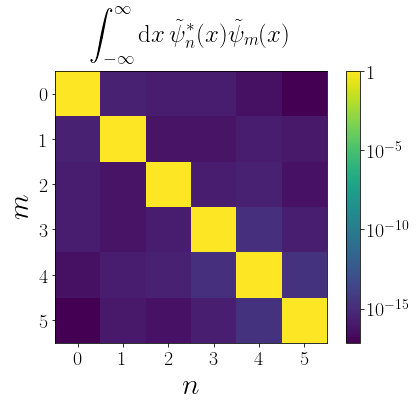

In [108]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

img  = ax.imshow(np.log10(np.abs(psi@psi.T)),cmap='viridis')


ticks = [0,1,2,3,4,5]
ax.set_xticks(ticks,[r'$%d$'%_ for _ in ticks])
ax.set_yticks(ticks,[r'$%d$'%_ for _ in ticks])
ax.tick_params(axis='both',which='major',direction='out',labelsize=20)
ax.set_title(r'$\displaystyle \int_{-\infty}^{\infty} {\rm d}{x} \, \tilde{\psi}^{*}_{n}(x) \tilde{\psi}_{m}(x)$',size=25,pad=30)
ax.set_xlabel(r'$n$',size=30)
ax.set_ylabel(r'$m$',size=30)

cbar = fig.colorbar(img)
cbar.ax.tick_params(labelsize=20)
ticks = [0,-5,-10,-15]
cbar.ax.set_yticks(ticks,[r'$1$']+[r'$10^{%d}$'%_ for _ in ticks[1:]])

plt.show()
fig.savefig(r'ho_orthonormality.pdf',bbox_inches='tight')

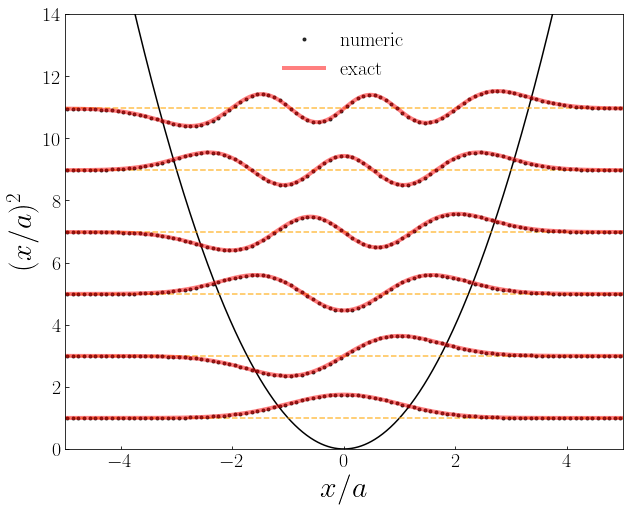

In [107]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(-5,5,1000)
ax.plot(x_,V(x_),color='k',alpha=1)

n    = E.shape[0]
psi_ = np.array([get_HO_psi(x_,_) for _ in range(n)])

scale = 1
for i in range(n):
    sign = np.sign(psi[i][1])#/np.sign(psi_[i][1])
    
    ax.axhline(E[i],color='orange',ls='--',alpha=0.7)
    ax.plot(x,scale*psi[i]/np.sqrt(h) + E[i],'k.',alpha=0.8,label=r'$\rm numeric$' if i==0 else '')
    ax.plot(x_,scale*psi_[i]+E[i],'r-',lw=4,alpha=0.5,label=r'$\rm exact$' if i==0 else '')

ax.set_xlim(-5,5)
ax.set_ylim(0,14)
ax.set_xlabel(r'$x/a$',size=30)
ax.set_ylabel(r'$(x/a)^2$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
ax.legend(fontsize=20,loc='upper center',frameon=False)

plt.show()
fig.savefig(r'ho_wfs.pdf',bbox_inches='tight')

# Comb Potential

In [7]:
def V(t,b=1,N=10,V0=1):
    return V0*((t % (1+b) > 1) | (t > N*(1 + b) - b))

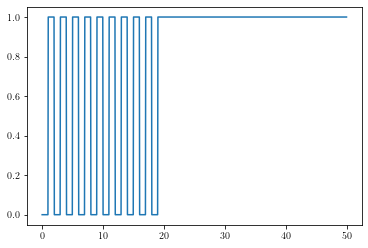

In [9]:
x = np.linspace(0,50,1000)
plt.plot(x,V(x))

In [65]:
N    = np.arange(1,9)
spec = []
b,V0   = 0.5,50
for _ in N:
    x,E,psi = solve_SE(0,100,1000,lambda t: V(t,b=b,N=_,V0=V0))
    E,psi   = E[E<V0],psi[E<V0]
    spec.append(E)

In [66]:
spec

[array([ 8.04453495, 30.81936364]),
 array([ 5.75920517,  8.04800496, 22.18396062, 30.89220638, 45.71124757]),
 array([ 5.669365  ,  5.85339834,  8.0480165 , 21.71924212, 22.69665617,
        30.89318733, 44.4255987 , 47.61963618]),
 array([ 5.63289196,  5.76011022,  5.89333187,  8.04801653, 21.53357479,
        22.19457093, 22.9203119 , 30.89320065, 43.92009681, 45.9378986 ,
        48.5971757 ]),
 array([ 5.61506532,  5.70397553,  5.81771756,  5.9131464 ,  8.04801653,
        21.44318162, 21.90069921, 22.50455104, 23.0325934 , 30.89320083,
        43.67067816, 45.04179932, 47.03518611, 49.12954285]),
 array([ 5.60512041,  5.66978519,  5.76041215,  5.8538885 ,  5.9242693 ,
         8.04801653, 21.39280595, 21.72398282, 22.19811722, 22.70272747,
        23.09595954, 30.89320083, 43.52958844, 44.51774258, 46.0167621 ,
        47.79482784, 49.44269134]),
 array([ 5.59903216,  5.64786325,  5.71982063,  5.80173176,  5.87750048,
         5.93109802,  8.04801653, 21.3619706 , 21.61141246, 21

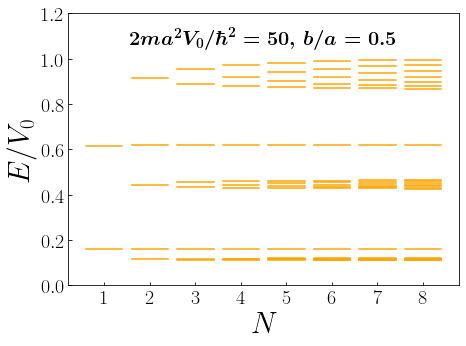

In [87]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

x_ = np.array([1e-1,1-1e-1])
for i in range(len(spec)):
    E = spec[i]/V0
    for _ in E:
        ax.plot(x_+i,2*[_],color='orange')

# ax.axhline(y=1,color='k',ls='--')
        
xticks = [0.5+i for i in range(len(spec))]
ax.set_xticks(xticks,[r'$%d$'%_ for _ in N])
ax.set_xlabel(r'$N$',size=30)
ax.set_ylabel(r'$E/V_0$',size=30)
ax.tick_params(axis='both',which='major',direction='in',labelsize=20)
ax.set_ylim(0,1.2)
ax.text(s=r'\boldmath $2 m a^2 V_0 / \hbar^2 = %d,\, b/a = %.1g$'%(V0,b),x=0.5,y=0.95,ha='center',va='top',transform=ax.transAxes,size=20)

plt.show()
fig.savefig(r'comb_spectrum.pdf',bbox_inches='tight')

In [ ]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(0,5,1000)
ax.plot(x_,V(x_),color='k',alpha=1)

scale = 1.8
for i in range(len(E)):
    
    ax.axhline(E[i],color='orange',ls='--',alpha=0.7)
    # ax.plot(x, + E[i],'k.',alpha=0.8,label=r'$\rm numeric$' if i==0 else '')
    ax.plot(x_,scale*psi[i]/np.sqrt(h)+E[i],'r-',lw=4,alpha=0.5)#,label=r'$\rm numeric$' if i==0 else '')

ax.set_xlim(0,5)
ax.set_ylim(0,21)
ax.set_xlabel(r'$x/a$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
# ax.legend(fontsize=20,loc='upper center',frameon=False)

plt.show()
fig.savefig(r'morse_wfs.pdf',bbox_inches='tight')

# Morse Potential

In [88]:
def V(t,D=20,a=1):
    return D*(1-np.exp(-a*(t-1)))**2

In [89]:
D,a = 20,0.75
x,E,psi = solve_SE(0,10,1000,lambda t: V(t,D=20,a=0.75))
E,psi   = E[E<D],psi[E<D]


h = x[1] - x[0]

In [90]:
E

array([ 3.26431543,  8.94132582, 13.47320064, 16.81434539, 18.95956552])

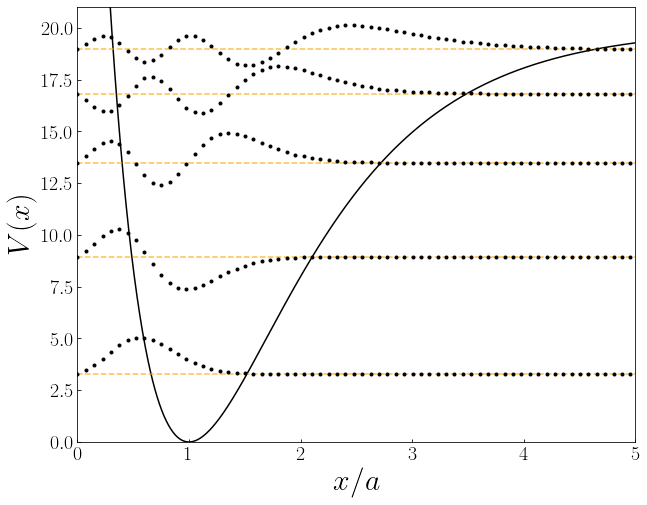

In [98]:
nrows,ncols = 1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10*ncols,8*nrows))

x_ = np.linspace(0,5,1000)
ax.plot(x_,V(x_),color='k',alpha=1)

scale = 1.8
for i in range(len(E)):
    
    ax.axhline(E[i],color='orange',ls='--',alpha=0.7)
    # ax.plot(x, + E[i],'k.',alpha=0.8,label=r'$\rm numeric$' if i==0 else '')
    ax.plot(x_[::15],scale*psi[i][::15]/np.sqrt(h)+E[i],'k.')#,label=r'$\rm numeric$' if i==0 else '')

ax.set_xlim(0,5)
ax.set_ylim(0,21)
ax.set_xlabel(r'$x/a$',size=30)
ax.set_ylabel(r'$V(x)$',size=30)
ax.tick_params(axis='both',which='major',labelsize=20,direction='in')
# ax.legend(fontsize=20,loc='upper center',frameon=False)

plt.show()
fig.savefig(r'morse_wfs.pdf',bbox_inches='tight')

# Hydrogen atom - radial equation

In [ ]:
def get_H_u(x,n,l):
    p,q = 2*l+1,n-l-1
    N   = (2/n)**l*np.sqrt((2/n)**3*np.math.factorial(n-l-1)/(2*n)/np.math.factorial(n+l))
    L   = assoc_laguerre(2*x/n,q,p)
    return N*x**(l+1)*np.exp(-x/n)*L

In [ ]:
def V(t,l=0):
    return l*(l+1)/t**2 - 2/t

In [ ]:
l = np.array([0,1,2])
N = 3
n = np.arange(1,N+1)
E_sols,u_sols = [],[]
for _ in l:
    x,E,u = solve_SE(0,100,1000,lambda t: V(t,_))
    E,u   = E[:N-_],u[:N-_]
    h = x[1] - x[0]
    u = u/np.sqrt(h)
    E_sols.append(_*[None]+list(E))
    u_sols.append(_*[None]+list(u))
    
E_sols,u_sols = E_sols[::-1],u_sols[::-1]

In [ ]:
nrows,ncols = 3,3
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

L,temp = np.meshgrid(l,n)
L,temp = L.T,temp.T

xmax = np.array([10,20,40])
ymax = np.array([0.35,0.45,0.75])
skip = np.array([2,3,5])

for i in range(nrows):
    for j in range(ncols):
        
        ax_ = ax[i][j]
        
        if E_sols[i][j] is not None:
            
            x_ = np.linspace(0,xmax[j],1000)
            u_ = get_H_u(x_,j+1,ncols-i-1)
            ax_.plot(x_,u_,'r-',lw=5,alpha=0.5,label=r'$\psi_{\rm exact}(u)/\sqrt{a}$' if i==0 else '')
            
            u    = u_sols[i][j]
            sign = np.sign(u[1])/np.sign(u_[1])
            ax_.plot(x[::skip[j]],sign*u[::skip[j]],'k.',alpha=0.8,label=r'$\psi_{\rm numeric}(u)$' if i==0 else '')
            
            ax_.set_xlim(1e-2,xmax[j])
            ax_.set_ylim(-ymax[i],ymax[i])
            
            ax_.text(s=r'\boldmath $u_{%d%d}(\frac{r}{a})$'%(j+1,nrows-i-1),size=30,x=0.85,y=0.9,ha='right',va='top',transform=ax_.transAxes,
                     bbox=dict(facecolor='none',edgecolor='black',lw=3,boxstyle='round,pad=0.5'))
            
            # ax_.set_xlabel(r'$r/r_0$',size=20,loc='right')
        
        else:
            ax_.spines['bottom'].set_visible(False)
            ax_.spines['left'].set_visible(False)
            ax_.set_yticks([],[])
            ax_.set_xticks([],[])
            
        ax_.spines['top'].set_visible(False)
        ax_.spines['right'].set_visible(False)
        ax_.spines['bottom'].set_position('zero')
        ax_.tick_params(axis='both',which='major',direction='in',labelsize=20)
        
fig.tight_layout()
plt.show()
fig.savefig(r'hydrogen_wfs.pdf',bbox_inches='tight')